# How to run this notebook (VERY IMPORTANT)

## The NumPy issue
- Please note that we use NumPy library within this notebook. 
    - An issue we found was that NumPy uses multithreading by default, and parallelizing a python function that uses NumPy via processes may result in each process creating a huge number of threads, each competing for CPU resources.
    - Hence we want to prevent each process from spawning multiple threads by default through NumPy.
    - Note NumPy isn't written in Python, and is actually written in C.
    - We need to change numerous thread settings within these C programs, and also within the NumPy program by changing environment variables for these libraries.
    - We can provide these environment variables through passing in command line arguments.
    - Hence please create the below bash script to run this notebook.
    - Run the script through "./<name_of_script>" in terminal
### How to test if thread parallelism is disabled within NumPy
#### Mac
- On terminal type in 'top' or go to activity monitor
- Run the Vanilla Gradient Descent script in this notebook, or the non-parallelized Stochastic Gradient Descent Script
- If you find more than 100% of the CPU being used (this depends on the number of cores in your CPU), then NumPy is using multithreading, and you haven't disabled it properly.
- Bottom of this article explains the issue https://in.nau.edu/arc/parallelism-in-python/#:~:text=The%20numpy%20library%20uses%20multithreading,processes%20on%20our%20compute%20nodes.
- If the fix is implemented correctly, you should the the python process's CPU usage being maximized at 100%.
- If you add more processes through our implementation, each process's CPU usage will be maximized at 100%.

### Bash Script
```
#!/bin/bash

#Activate your virtual environment
source <location of virtual_env>/bin/activate

# Launch VSCode with specific environment variables.
# If you don't open notebooks via vscode and wish to do it through jupyter notebook instead, comment the line below and uncomment the line 2 lines below it

OMP_NUM_THREADS=1 OPENBLAS_NUM_THREADS=1 MKL_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 VECLIB_MAXIMUM_THREADS=1 BLIS_NUM_THREADS=1 code .
# OMP_NUM_THREADS=1 OPENBLAS_NUM_THREADS=1 MKL_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 VECLIB_MAXIMUM_THREADS=1 BLIS_NUM_THREADS=1 jupyter notebook .
```

## Virtual Environment
- The virtual environment should have the packages seen below in the imports.
    - SGD_by_process is an internal python file for this notebook.

## Preliminary work
- Below is some preliminary work where we conduct standard linear regression and then polynomial linear regression using existing package sklearn
- We show MSE for both fits


- We will be doing linear regression in this notebook: $y = X\beta + \epsilon$
- We will be choosing only a single regressor to predict the dependent variable
- We have chosen a dataset which requires polynomial linear regression
- As a result the line we're trying to fit is $y=\beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3 + \epsilon$
- Need to transform (N * 1) matrix $X$ to (N * 4) matrix as a result where ith row is $\begin{bmatrix} 1 & x_i & x_i^2 & x_i^3 \end{bmatrix}$
- After this transformation, initially we will use the closed form solution for the Least Squares Estimator to fit the data: $\hat{\beta} = (X^T X)^{-1}X^T y$
    - Here $\hat{\beta} = \begin{bmatrix} \hat{\beta_0} \\ \hat{\beta_1} \\ \hat{\beta_2} \\ \hat{\beta_3} \end{bmatrix}$
- Then we move onto an iterative gradient descent approach for LSE Estimation of Linear Regression. SGD is one of the algorithms here!
    - Batch Gradient Descent where we use the entire dataset: $\hat{\beta}_{k+1} = \hat{\beta}_{k} - \alpha X^T(\hat{y} - y)$
        - $\hat{\beta}_{k} = \begin{bmatrix} \hat{\beta_0}_{k} \\ \hat{\beta_1}_{k} \\ \hat{\beta_2}_{k} \\ \hat{\beta_3}_{k} \end{bmatrix}, y = \begin{bmatrix} y_1 \\ y_2 \\ \vdots \\ y_n \end{bmatrix}, X = \begin{bmatrix} 1 & x_1 & x_1^2 & x_1^3 \\ 1 & x_2 & x_2^2 & x_2^3 \\ \vdots & \ddots \\ 1 & x_n & x_n^2 & x_n^3 \end{bmatrix}$
    - Stochastic Gradient Descent where we use just a single randomly selected sample: $\hat{\beta}_{k+1} = \hat{\beta}_{k} - \alpha(\hat{y_i} - y) x_i^T$
        - Now the $y, y_i$ are both scalar, and $x_i$ is not a matrix but rather a vector of a single randomly selected row from $X$

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from multiprocessing import Pool
import SGD_by_process
from datetime import datetime
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed

In [ ]:
dataframe = pd.read_excel('dataset1/dataset1.xlsx')
print(dataframe.shape)
dataframe.describe()

In [24]:
X = dataframe['V'].sort_values()
X = (X-X.mean()) / X.std()
y = dataframe['AT'][X.index].values
y = (y-y.mean()) / y.std()

X = np.reshape(X.values, (-1,1))

In [ ]:
plt.scatter(X, y)
plt.title("Dataset")
plt.xlabel("Exhaust Vacuum")
plt.ylabel("Average Temperature")
plt.show()

In [26]:
lr = LinearRegression()
lr.fit(X, y)
y_hat_sklearn = lr.predict(X)

pr = PolynomialFeatures(degree=3)
X_poly = pr.fit_transform(X)
lr_poly = LinearRegression()
lr_poly.fit(X_poly, y)
y_hat_poly_sklearn = lr_poly.predict(X_poly)


In [ ]:
plt.scatter(X, y, color = 'blue', label='Observed Data')
plt.plot(X, y_hat_sklearn, color = 'firebrick', label='OLS fit(sklearn package)')
plt.plot(X, y_hat_poly_sklearn, color = 'green', label='Polynomial fit(sklearn package)')
plt.title("Dataset and appropriate OLS fits")
plt.ylabel("Normalized Temperature (T)")
plt.xlabel("Normalized Exhaust Vacuum (V)")
plt.legend()
plt.show()

In [ ]:
y_hat_sklearn = lr.predict(X)
y_hat_poly_sklearn = lr_poly.predict(X_poly)

print("mean squared error for standard linear:", mean_squared_error(y, y_hat_sklearn))
print("mean squared error for linear polynomial:", mean_squared_error(y, y_hat_poly_sklearn))

# Going from built-in package to implementing it ourselves

- Now using the dataset, we will conduct linear regression, but this time using matrix multiplication and numpy.
- we will implement a closed-form based based algorithm before moving onto a gradient descent based algorithm.

In [29]:
'''
Converts an (N * 1) matrix into a (N * h) matrix where h is the number of basis functions ()
The degree of the polynomial is (h-1)
'''
def polynomial_basis_function_transformation(X, h):
    powers = np.arange(h)
    X_poly = np.power(X, powers)
    return X_poly

'''
Conducts Linear Regression but initially transforms data using polynomial basis functions
Takes in an (N * 1) matrix, converts it into a (N * h) matrix
Performs linear regression on the (N*h) matrix resulting in h weights - betas
Returns the predictions only
'''
def lin_reg_poly_closed_form(X, y, h):
    X_poly = polynomial_basis_function_transformation(X, h)
    beta_hat_poly = np.linalg.pinv(X_poly.T @ X_poly) @ X_poly.T @ y
    y_hat_poly = X_poly @ beta_hat_poly
    return y_hat_poly


In [30]:
y_hat = lin_reg_poly_closed_form(X, y, 2)
y_hat_poly = lin_reg_poly_closed_form(X, y, 4)

Note the plots are identical and MSE difference is very small (due to floating point representation error). We can be confident we implemented linear regression correctly

In [ ]:
plt.scatter(X, y, color = 'blue', label="Observed data")
plt.plot(X, y_hat, color = 'firebrick', label="OLS estimate")
plt.plot(X, y_hat_poly, color = 'green', label='Polynomial Estimate (degree = 3)')
plt.title("Dataset and appropriate fits")
plt.ylabel("Normalized Temperature (T)")
plt.xlabel("Normalized Exhaust Vacuum (V)")
plt.legend()
plt.show()

print("mean squared error for linear polynomial through numpy (closed form):", mean_squared_error(y, y_hat_poly))

# Implementing the Batch Gradient Descent algorithm for linear regression

- We have implemented the closed form solution for polynomial linear regression ourselves above, moving away from sklearn as a package
- We now look to implement an iterative algorithm, useful when closed form solution is computationally prohibitive, such as when $X^TX$ is $10,000*10,000$ leading to matrix inversion times being extremely long (in the above case it is only $4 * 4$)
- We will initially implement Batch Gradient Descent and parallelize it before finally moving onto Stochastic Gradient Descent, and then parallelizing Stochastic Gradient Descent

## Non Parallelized version

In [11]:
'''
Conducts Linear Regression but initially transforms data using polynomial basis functions
Takes in an (N * 1) matrix, converts it into a (N * h) matrix
Performs linear regression on the (N*h) matrix resulting in h weights - betas
But this time linear regression is conducted through iterative batch gradient descent
MSE as you iterate through the algorithm is shown
Returns the predictions only
'''
def lin_reg_poly_bgd(X, y, h, alpha, n):
    X_poly = polynomial_basis_function_transformation(X, h)
    beta_hat_poly = np.random.rand(h)
    for i in range(n):
        y_hat_poly = X_poly @ beta_hat_poly
        beta_hat_poly = beta_hat_poly - alpha * (X_poly.T @ (y_hat_poly - y))
        print("MSE in iteration", i, ": ", mean_squared_error(y, y_hat_poly))
    return y_hat_poly
    

In [ ]:
y_hat_poly_bgd = lin_reg_poly_bgd(X, y, 4, 0.00001, 5000)

In [ ]:
plt.scatter(X, y, color = 'blue', label='Observed Data')
plt.plot(X, y_hat, color = 'firebrick', label='OLS fit')
plt.plot(X, y_hat_poly_bgd, color = 'green', label='GD polynomial fit')
plt.title("Dataset and appropriate fits")
plt.ylabel("Normalized Temperature (T)")
plt.xlabel("Normalized Exhaust Vacuum (V)")
plt.legend()
plt.show()

print("mean squared error for linear polynomial through numpy (gradient descent):", mean_squared_error(y, y_hat_poly_bgd))

# Stochastic Gradient Descent
- We will now implement the non-parallelized version of SGD

## Non-Parallelized Version

In [12]:
'''
Conducts Linear Regression but initially transforms data using polynomial basis functions
Takes in an (N * 1) matrix, converts it into a (N * h) matrix
Performs linear regression on the (N*h) matrix resulting in h weights - betas
But this time linear regression is conducted through iterative gradient descent
Specifically stochastic gradient descent where we just choose a single sample from the the dataset
MSE as you iterate through the algorithm is shown
Returns the predictions only
'''
def lin_reg_poly_sgd(X, y, h, alpha, n):
    X_poly = polynomial_basis_function_transformation(X, h)
    beta_hat_poly = np.random.rand(h)
    for i in range(n):
        idx = np.random.randint(0, X_poly.shape[0])
        X_sample = X_poly[idx, :]
        y_sample = y[idx]
        y_hat_sample_poly = X_sample @ beta_hat_poly
        beta_hat_poly = beta_hat_poly - alpha * (X_sample.T * (y_hat_sample_poly - y_sample))
        
        y_hat_poly = X_poly @ beta_hat_poly
        if i % 100000 == 0:
            print("MSE in iteration", i, ": ", mean_squared_error(y, y_hat_poly))
    return y_hat_poly

NOTE: The below cell took 2 mins to run on apple M1 MacBook Air

In [ ]:
y_hat_poly_sgd = lin_reg_poly_sgd(X, y, 4, 0.00001, 5000000)

In [ ]:
plt.scatter(X, y, color = 'blue', label='Observed Data')
plt.plot(X, y_hat, color = 'firebrick', label='OLS fit')
plt.plot(X, y_hat_poly_sgd, color = 'green', label='SGD polynomial fit')
plt.title("Dataset and appropriate fits")
plt.ylabel("Normalized Temperature (T)")
plt.xlabel("Normalized Exhaust Vacuum (V)")
plt.legend()
plt.show()

print("mean squared error for linear polynomial through numpy (stochastic gradient descent):", mean_squared_error(y, y_hat_poly_sgd))

## Building off of Zinkevich et al's attempt at parallelizing SGD - SGD Parallelism via Processes
- Implementing parallelization of SGD according to the paper "Parallelized Stochastic Gradient Descent" published by Zinkevich et al (References in report).
- The key difference is we are parallelizing across processes within the same machine whereas they are parallelizing with different machines entirely.
- We have extended upon the results achieved by the paper slightly. 
- The procedure is explained below.
- The variable notations below are different than the variable notations in the paper.

### Preliminary
- Please read the descriptions before each function and try understand what each function does
    - lin_reg_poly_sgd_parallel implements the parallel SGD algorithm with t processes for n iterations. Returns the MSE after n iterations.
    - get_mse_mean_var implements the parallel SGD algorithm with t processes for n iterations an i amount of times and returns the sample mean of MSEs and sample variance of MSEs.
    - mse_mean_var_evolution allows us to see the evolution of the average and sample variance of MSEs as you increase the iterations. This provides us snapshots of model performances throughout training for different process counts in the parallel SGD algorithm.

### Procedure
1. Repeat the below for t = 1, 2, 4, 8 (We conduct the experiment for 1 process, 2 processes, 4 processes, 8 processes in the algorithm).
2. Call mse_mean_var_evolution() with the above different values of t. This tells us how the training process evolves when using different number of processes achieving parallelism. Each call to mse_mean_var_evolution returns an array of MSE means and variances, each as you increase n or in other words, as train the model longer.
3. We plot the array of MSE means and MSE variances for different process counts on the same plot allowing us to compare.

### Results
We successfully replicated results achieved by Zinkevich et al. He noticed that theoretically as you increase processor count, you should achieve a reduction in variance for a fixed iteration n. He also noted that you should observe a lower mean MSE as you increase the process count. This is the performance benefit to parallelism - we see better performances earlier on in training as a result of the parallelism. This is because we train t models in parallel, resulting in t models seeing different subsets of the data. In the end when you aggregate all the models, the resulting model will have seen more of the data in the same wall clock time compared to a model with a lower process count. However the benefits of parallelism diminish after you train for an extended amount of time as performances of all models converge to the lowest reference MSE as seen in Batch Gradient Descent.

We also see a trade-off when parallelizing via processes. A careful balance between number of processes and learning rate is required to obtain the best possible model within a given time constraint.

In [13]:
'''
Conducts Linear Regression but initially transforms data using polynomial basis functions.
Takes in an (N * 1) matrix, converts it into a (N * h) matrix
Performs linear regression on the (N*h) matrix resulting in h weights - betas
But this time linear regression is conducted through an iterative gradient descent algorithm. 
Specifically stochastic gradient descent where we just choose a single sample from the the dataset.

This time t processes conduct SGD in parallel on the entire dataset exactly like the procedure in Zinkevich et al. 
Each process updates parameters for n iterations.

After each thread has returned estimates beta_hats, we aggregate them to get the final beta_hat

Returns the MSE and time it took for parallel computations as we are only measuring performance.
'''

def lin_reg_poly_sgd_parallel(X, y, h, alpha, n, t):
    start = datetime.now()
    
    X_poly = polynomial_basis_function_transformation(X, h)
    
    # Diff1 is the amount of time it took to do the matrix multiplication
    curr1 = datetime.now()
    diff1 = curr1 - start
    
    with Pool(processes=t) as p:
        # Diff2 is the amount of time it took to create a pool of t processes
        curr2 = datetime.now()
        diff2 = curr2 - curr1
        
        outputs = p.starmap(SGD_by_process.lin_reg_poly_sgd, [[X_poly, y, h, alpha, n]] * t)
        outputs = np.array(outputs)
        
        # Diff3 is the amount of time it took to process t SGD algorithms in parallel in a pool of t processes
        curr3 = datetime.now()
        diff3 = curr3 - curr2
        
    beta_hat_poly = np.sum(outputs, axis=0) / t
    y_hat_poly = X_poly @ beta_hat_poly
    
    return mean_squared_error(y, y_hat_poly), diff2 + diff3

In [14]:
'''
This function calls the above function but for i amount of times.
Lets say we wanted to test the parallelized SGD algorithm after 1000 iterations of the dataset. 
We want to measure the benefits of parallelism for SGD so rationally we look at the MSE after conducting the parallel SGD algorithm (as described by the paper) with 1 process(equivalent to non parallel SGD), 2 processes, 4 processes, 8 processes, etc.
But running the SGD algorithm with t processes for n iterations twice will result in two different MSEs. This is because of the inherent stochastic nature of the algorithm where we randomly sample an observation.
Hence to get a more informative measure of the performance of the parallelized SGD algorithm with t processes after n iterations, we need to repeat the experiment i times, and obtain a sample of the MSEs, and then calculate the mean and the variance.
Comparing the mean of the MSE samples of two different stochastic models after n iterations makes more sense than comparing single observations of the MSEs.
We also compare the variances, and desire such that the variances of the MSE samples reduces as we increase the number of processes t used in training a model. This indicates that parallelism has some benefit.
'''

def get_mse_mean_var(X, y, h, alpha, n, t, i):
    mses = []
    times = []
    for i in range(i):
        mse, time_taken = lin_reg_poly_sgd_parallel(X, y, h, alpha, n, t)
        mses.append(mse)
        times.append(time_taken)
    mses = np.array(mses)
    times = np.array(times)
    return np.mean(mses), np.var(mses), np.mean(times)
    
    
'''
We have discussed how the above function measures the performance of a parallelized SGD algorithm with t threads after n iterations.
We want to see if parallelism has any sort of benefit throughout training, i.e. if we obtain a lower average MSE for the same number of iterations for a model with a higher process count, or maybe a lower variance of MSE for a higher process count if the MSEs are the same after n iterations.
Hence the below function implements the above function but gives us snapshots of model performance throughout training. This is allowing us to see the evolution of the performance (through average MSE) for different models throughout training.
'''
def mse_mean_var_evolution(X, y, h, alpha, n, t, i, means, variances, times):
    x_ = [10, 100, 500, 1000, 2000, 3000, 4000, 5000, 7000, 9000]
    for x in x_:
        mean, var, time_mean = get_mse_mean_var(X, y, h, alpha, x, t, i)
        means.append(mean)
        variances.append(var)
        times.append(time_mean)
        print(means)
        print(variances)
        print(times)

NOTE: The below cell took 15 minutes to run on apple M1 Macbook air

In [ ]:
means1 = []
variances1 = []
times1 = []
mse_mean_var_evolution(X, y, 4, 0.0001, 10, 1, 100, means1, variances1, times1)

NOTE: The below cell took 16:15 minutes to run on apple M1 Macbook air

In [ ]:
means2 = []
variances2 = []
times2 = []
mse_mean_var_evolution(X, y, 4, 0.0001, 10, 2, 100, means2, variances2, times2)

NOTE: The below cell took 20:00 minutes to run on apple M1 Macbook air

In [ ]:
means4 = []
variances4 = []
times4 = []
mse_mean_var_evolution(X, y, 4, 0.0001, 10, 4, 100, means4, variances4, times4)

NOTE: The below cell took 25 minutes to run on apple M1 Macbook air

In [ ]:
means8 = []
variances8 = []
times8 = []
mse_mean_var_evolution(X, y, 4, 0.0001, 10, 8, 100, means8, variances8, times8)

In [313]:
# We convert the times from timedelta objects to double, and print to verify
times1 = list(map(lambda x: x.total_seconds(), times1))
times2 = list(map(lambda x: x.total_seconds(), times2))
times4 = list(map(lambda x: x.total_seconds(), times4))
times8 = list(map(lambda x: x.total_seconds(), times8))
print(times1)
print(times8)

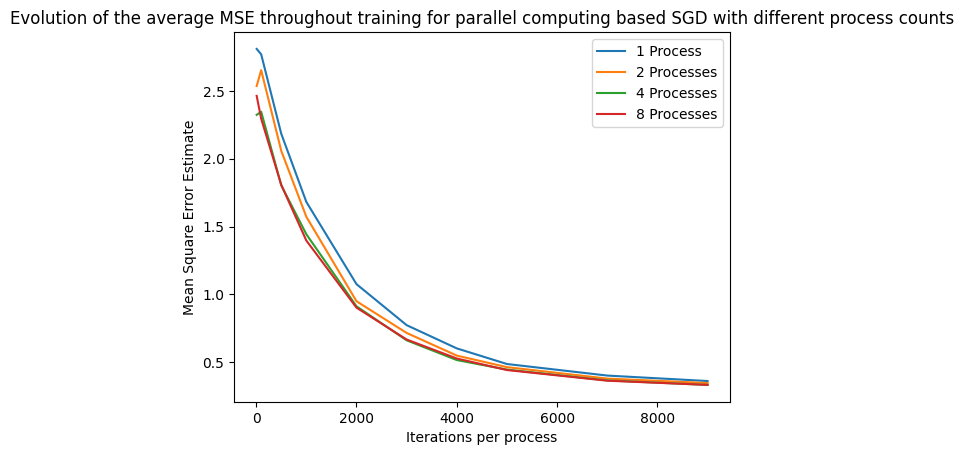

In [305]:
plt.plot([10, 100, 500, 1000, 2000, 3000, 4000, 5000, 7000, 9000], means1, label = "1 Process")
plt.plot([10, 100, 500, 1000, 2000, 3000, 4000, 5000, 7000, 9000], means2, label = "2 Processes")
plt.plot([10, 100, 500, 1000, 2000, 3000, 4000, 5000, 7000, 9000], means4, label = "4 Processes")
plt.plot([10, 100, 500, 1000, 2000, 3000, 4000, 5000, 7000, 9000], means8, label = "8 Processes")
plt.title("Evolution of the average MSE throughout training for parallel computing based SGD with different process counts")
plt.ylabel("Mean Square Error Estimate")
plt.xlabel("Iterations per process")
plt.legend()
plt.show()

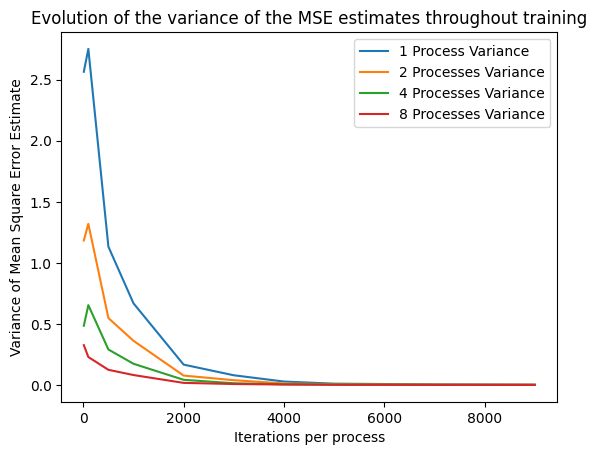

In [306]:
plt.plot([10, 100, 500, 1000, 2000, 3000, 4000, 5000, 7000, 9000], variances1, label = "1 Process Variance")
plt.plot([10, 100, 500, 1000, 2000, 3000, 4000, 5000, 7000, 9000], variances2, label = "2 Processes Variance")
plt.plot([10, 100, 500, 1000, 2000, 3000, 4000, 5000, 7000, 9000], variances4, label = "4 Processes Variance")
plt.plot([10, 100, 500, 1000, 2000, 3000, 4000, 5000, 7000, 9000], variances8, label = "8 Processes Variance")
plt.title("Evolution of the variance of the MSE estimates throughout training")
plt.ylabel("Variance of Mean Square Error Estimate")
plt.xlabel("Iterations per process")
plt.legend()
plt.show()

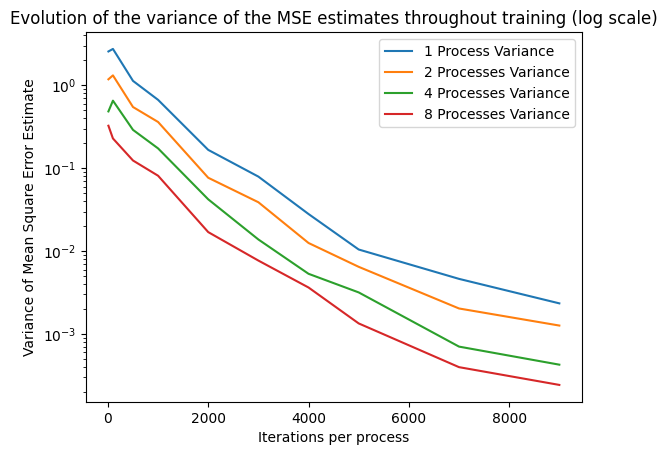

In [307]:
plt.yscale("log")
plt.plot([10, 100, 500, 1000, 2000, 3000, 4000, 5000, 7000, 9000], variances1, label = "1 Process Variance")
plt.plot([10, 100, 500, 1000, 2000, 3000, 4000, 5000, 7000, 9000], variances2, label = "2 Processes Variance")
plt.plot([10, 100, 500, 1000, 2000, 3000, 4000, 5000, 7000, 9000], variances4, label = "4 Processes Variance")
plt.plot([10, 100, 500, 1000, 2000, 3000, 4000, 5000, 7000, 9000], variances8, label = "8 Processes Variance")
plt.title("Evolution of the variance of the MSE estimates throughout training (log scale)")
plt.ylabel("Variance of Mean Square Error Estimate")
plt.xlabel("Iterations per process")
plt.legend()
plt.show()

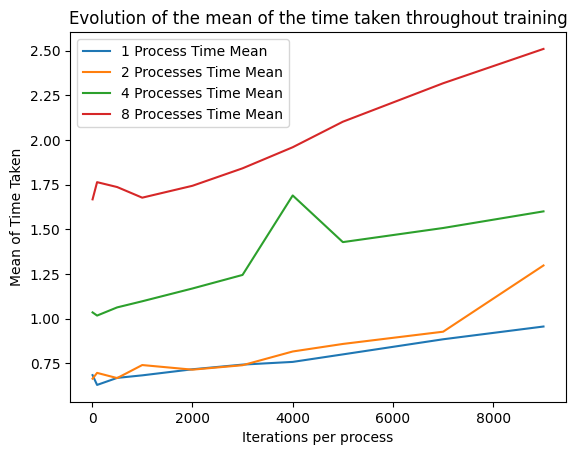

In [314]:
plt.plot([10, 100, 500, 1000, 2000, 3000, 4000, 5000, 7000, 9000], times1, label = "1 Process Time Mean")
plt.plot([10, 100, 500, 1000, 2000, 3000, 4000, 5000, 7000, 9000], times2, label = "2 Processes Time Mean")
plt.plot([10, 100, 500, 1000, 2000, 3000, 4000, 5000, 7000, 9000], times4, label = "4 Processes Time Mean")
plt.plot([10, 100, 500, 1000, 2000, 3000, 4000, 5000, 7000, 9000], times8, label = "8 Processes Time Mean")
plt.title("Evolution of the mean of the time taken throughout training")
plt.ylabel("Mean of Time Taken")
plt.xlabel("Iterations per process")
plt.legend()
plt.show()

## Parallelism with threads instead of processes

If we wanted to experiment with threads instead of processes, we could use the below function. Please note no experiments have been conducted for the Zinkevich et al. algorithm through thread based parallelism.

In [39]:
'''
Conducts Linear Regression but initially transforms data using polynomial basis functions
Takes in an (N * 1) matrix, converts it into a (N * h) matrix
Performs linear regression on the (N*h) matrix resulting in h weights - betas
But this time linear regression is conducted through iterative gradient descent
Specifically stochastic gradient descent where we just choose a single sample from the the dataset

This time t threads conduct sgd in parallel on the entire dataset. 
Each thread does it for n iterations.

After each thread has returned estimates beta_hats, we aggregate them to get the final beta_hat

Returns the predictions only
'''

def lin_reg_poly_sgd_parallel_threads(X, y, h, alpha, n, t):
    start = datetime.now()
    X_poly = polynomial_basis_function_transformation(X, h)
    
    curr1 = datetime.now()
    diff1 = curr1 - start
    
    with ThreadPoolExecutor(max_workers=t) as executor:
        curr2 = datetime.now()
        diff2 = curr2 - curr1
        
        futures = [executor.submit(SGD_by_process.lin_reg_poly_sgd, X_poly, y, h, alpha, n) for _ in range(t)]
        outputs = []
        for future in as_completed(futures):
            outputs.append(future.result())
        outputs = np.array(outputs)
        
        curr3 = datetime.now()
        diff3 = curr3 - curr2
        
    beta_hat_poly = np.sum(outputs, axis=0) / t
    y_hat_poly = X_poly @ beta_hat_poly
    
    print("mean squared error for linear polynomial through SGD (parallel):", mean_squared_error(y, y_hat_poly))
    print("Times:")
    print(diff1)
    print(diff2)
    print(diff3)
    
    return y_hat_poly

In [ ]:
lin_reg_poly_sgd_parallel_threads(X, y, 4, 0.0000001, 500, 1)

In [ ]:
lin_reg_poly_sgd_parallel_threads(X, y, 4, 0.0000001, 500000, 2)

In [ ]:
lin_reg_poly_sgd_parallel_threads(X, y, 4, 0.0000001, 500000, 3)

In [ ]:
lin_reg_poly_sgd_parallel_threads(X, y, 4, 0.0000001, 500000, 4)